In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, transpile, schedule as build_schedule
from qiskit.circuit import Gate, Parameter
import qiskit.compiler.transpiler as transpiler
from qiskit.transpiler.passes import DynamicalDecoupling
from qiskit.circuit.library import XGate
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import MeasurementFilter, complete_meas_cal
from qiskit_experiments.database_service import DbExperimentDataV1 as DbExperimentData

from cross_resonance import LinearizedCR, PulseEfficientCR, DefaultRtt, cx_circuit
from calibrations import MeasurementErrorMitigation, MeasurementErrorExperiment, LinearizedCRRabiExperiment
from model_circuits import single_step_no_opt, single_step, two_steps, add_dynamical_decoupling
from dynamics import plot_curve, plot_counts_with_curve

In [2]:
nsites = 4

J = 2. # Hamiltonian J parameter
mu = 2. # Hamiltonian mu parameter

M = 8 # number of Trotter steps
omegadt = 0.2 # Trotter step size

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')
physical_qubits = [1, 4, 7, 6]

In [4]:
calibrations_file_name = 'kawasaki_{}.h5'.format('_'.join(str(q) for q in physical_qubits))
if not os.path.exists(calibrations_file_name):
    with h5py.File(calibrations_file_name, 'r+') as out:
        dataset = out.create_dataset('physical_qubits', (4,), dtype='i')
        dataset[:] = physical_qubits
        
        exp = MeasurementErrorExperiment(physical_qubits, circuits_per_state=(backend.configuration().max_experiments // 32))
        exp_data = exp.run(backend=backend, shots=8192)
        print(exp_data.experiment_id)
        exp_data.block_for_results()
        cal_matrix = exp_data.analysis_results()[0].value
        out.create_dataset('measurement_error_matrix', data=cal_matrix)
        
        dataset_alpha = out.create_dataset('alpha', (3, 2), dtype='f')
        dataset_phi0 = out.create_dataset('phi0', (3, 2), dtype='f')
        dataset_amp = out.create_dataset('amp', (3, 2), dtype='f')
        dataset_offset = out.create_dataset('offset', (3, 2), dtype='f')
        dataset_chisq = out.create_dataset('chisq', (3,), dtype='f')

        for ipair, qubits in enumerate(zip(physical_qubits[:-1], physical_qubits[1:])):
            exp = LinearizedCRRabiExperiment(qubits, backend)
            exp.circuits_per_point = backend.configuration().max_experiments // exp.width_values.shape[0] // 2
            exp_data = exp.run(backend=backend, shots=8192)
            print(exp_data.experiment_id)
            exp_data.block_for_results()
            results = exp_data.analysis_results()
            dataset_alpha[ipair, 0] = results[0].value.value
            dataset_alpha[ipair, 1] = results[0].value.stderr
            dataset_phi0[ipair, 0] = results[1].value.value
            dataset_phi0[ipair, 1] = results[1].value.stderr
            dataset_amp[ipair, 0] = results[2].value.value
            dataset_amp[ipair, 1] = results[2].value.stderr
            dataset_offset[ipair, 0] = results[3].value.value
            dataset_offset[ipair, 1] = results[3].value.stderr
            dataset_chisq[ipair] = results[4].chisq

In [5]:
crs_linear = {
    (0, 1): LinearizedCR(backend, tuple(physical_qubits[:2])),
    (1, 2): LinearizedCR(backend, tuple(physical_qubits[1:3])),
    (2, 3): LinearizedCR(backend, tuple(physical_qubits[2:]))
}
crs_pe = {
    (0, 1): PulseEfficientCR(backend, tuple(physical_qubits[:2])),
    (1, 2): PulseEfficientCR(backend, tuple(physical_qubits[1:3])),
    (2, 3): PulseEfficientCR(backend, tuple(physical_qubits[2:]))
}
crs_default = dict((qubits, DefaultRtt()) for qubits in [(0, 1), (1, 2), (2, 3)])
for qubits, cr in crs_default.items():
    cr.native_direction = crs_linear[qubits].native_direction

cxs = {
    (0, 1): cx_circuit(backend, *tuple(physical_qubits[:2])),
    (1, 0): cx_circuit(backend, *tuple(physical_qubits[1::-1]))
}
mem = MeasurementErrorMitigation(backend, physical_qubits)

with h5py.File(calibrations_file_name, 'r') as source:
    for ipair in range(3):
        lcr = crs_linear[(ipair, ipair + 1)]

        if lcr.native_direction:
            qubits = (lcr.z_qubit, lcr.x_qubit)
        else:
            qubits = (lcr.x_qubit, lcr.z_qubit)

        lcr.alpha = source['alpha'][ipair, 0]
        lcr.phi0 = source['phi0'][ipair, 0]

    _, state_labels = complete_meas_cal(qubit_list=list(range(nsites)), qr=QuantumRegister(4), circlabel='mcal')
    mem.filter = MeasurementFilter(source['measurement_error_matrix'][:], state_labels)

In [6]:
def trotter_step_circuits(crs=None, cxs=None, optimization_level=1, with_dd=False):
    if crs:
        single_step_circuit = single_step(J, mu, omegadt, crs=crs, cxs=cxs)
        two_step_circuit = two_steps(J, mu, omegadt, crs=crs, cxs=cxs)
    else:
        single_step_circuit = single_step_no_opt(J, mu, omegadt)
        two_step_circuit = single_step_circuit.compose(single_step_circuit)
    
    circuits = []
    for nrep in range(1, M + 1):
        circuit = QuantumCircuit(nsites, nsites)
        circuit.x(1)
        circuit.x(3)

        for _ in range(nrep // 2):
            circuit.compose(two_step_circuit, inplace=True)
                
        if nrep % 2 == 1:
            circuit.compose(single_step_circuit, inplace=True)
            
        circuit.measure(circuit.qregs[0], circuit.cregs[0])
        circuits.append(circuit)
    
    if with_dd:
        circuits = transpile_with_dynamical_decoupling(circuits, backend, physical_qubits, optimization_level=optimization_level)
    else:
        circuits = transpile(circuits, backend=backend, initial_layout=physical_qubits, optimization_level=optimization_level)
    circuits *= 10
    
    return circuits

In [7]:
from qiskit.transpiler.preset_passmanagers import level_0_pass_manager, level_1_pass_manager, level_2_pass_manager, level_3_pass_manager
preset_pms = [level_0_pass_manager, level_1_pass_manager, level_2_pass_manager, level_3_pass_manager]

def _transpile_circuit(circuit_config_tuple):
    circuit, transpile_config = circuit_config_tuple

    pass_manager_config = transpile_config["pass_manager_config"]

    # we choose an appropriate one based on desired optimization level
    level = transpile_config["optimization_level"]

    pass_manager = preset_pms[level](pass_manager_config)
    
    default_passes = pass_manager.passes()
    scheduling = default_passes[-2]['passes']
    dd = DynamicalDecoupling(pass_manager_config.instruction_durations, dd_sequence=[XGate(), XGate()])
    scheduling.append(dd)
    pass_manager.replace(-2, scheduling)

    result = pass_manager.run(
        circuit, callback=transpile_config["callback"], output_name=transpile_config["output_name"]
    )
    
    return result

def transpile_with_dynamical_decoupling(circuits, backend, initial_layout, optimization_level=1):
    transpile_args = transpiler._parse_transpile_args(
        circuits, # circuits,
        backend, # backend,
        None, # basis_gates,
        None, # coupling_map,
        None, # backend_properties,
        initial_layout, # initial_layout,
        None, # layout_method,
        None, # routing_method,
        None, # translation_method,
        'alap', # scheduling_method,
        None, # instruction_durations,
        None, # dt,
        None, # approximation_degree,
        None, # seed_transpiler,
        optimization_level, # optimization_level,
        None, # callback,
        None, # output_name,
        None  # timing_constraints,
    )

    transpiler._check_circuits_coupling_map(circuits, transpile_args, backend)

    # Transpile circuits in parallel
    return transpiler.parallel_map(_transpile_circuit, list(zip(circuits, transpile_args)))    

In [8]:
def combined_and_corrected_counts(job, exp_block_size):
    raw_counts = job.result().get_counts()
    counts = raw_counts[:exp_block_size]
    for iexp, cdict in enumerate(raw_counts[exp_block_size:]):
        ic = iexp % exp_block_size
        for key, value in cdict.items():
            try:
                counts[ic][key] += value
            except KeyError:
                counts[ic][key] = value

    return mem.apply(counts)

## Define and submit all circuits

In [9]:
# circuits = trotter_step_circuits(crs=crs_linear, cxs=cxs, with_dd=True)
# job_linear = backend.run(circuits, shots=8192)
# print('linear', job_linear.job_id())
job_linear = backend.retrieve_job('616e3d7d9c88ce29cab0dd29')

In [10]:
# circuits = trotter_step_circuits(crs=crs_pe, cxs=cxs, with_dd=True)
# job_pe = backend.run(circuits, shots=8192)
# print('pe', job_pe.job_id())
job_pe = backend.retrieve_job('616e3d81dd30e9e190e60f20')

In [11]:
# circuits = trotter_step_circuits(optimization_level=3, with_dd=True)
# job_naive = backend.run(circuits, shots=8192)
# print('naive', job_naive.job_id())
job_naive = backend.retrieve_job('616e3d921cc68111ce985e7a')

In [12]:
# circuits = trotter_step_circuits(crs=crs_default, with_dd=True)
# job_default = backend.run(circuits, shots=8192)
# print('default', job_default.job_id())
job_default = backend.retrieve_job('616e3d97ae533377508046fd')

## Forward steps with LinearizedCR

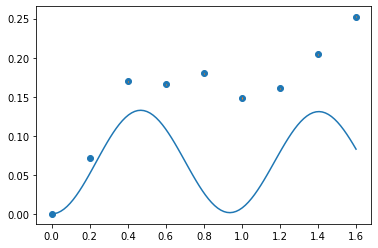

In [13]:
plot_counts_with_curve(combined_and_corrected_counts(job_linear, M), nsites, J, mu, omegadt, M)

## Forward steps with Pulse-Efficient CR

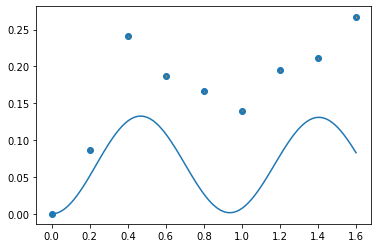

In [14]:
plot_counts_with_curve(combined_and_corrected_counts(job_pe, M), nsites, J, mu, omegadt, M)

## Forward with naive implementation (optimization level 3)

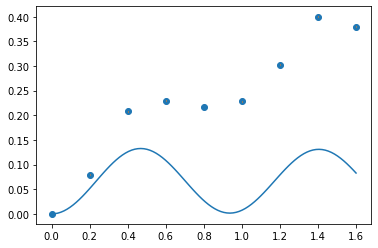

In [15]:
plot_counts_with_curve(combined_and_corrected_counts(job_naive, M), nsites, J, mu, omegadt, M)

## Forward steps with CNOT-based Rtt

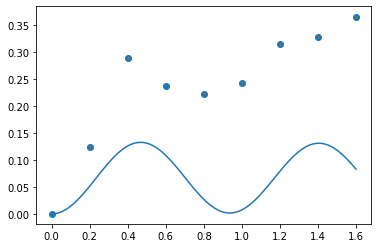

In [17]:
plot_counts_with_curve(combined_and_corrected_counts(job_default, M), nsites, J, mu, omegadt, M)